### Keertana V. Chidambaram
### MACS 30250 - PS 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde
import timeit
from sklearn.linear_model import LogisticRegression
import random
from sklearn.model_selection import train_test_split
import multiprocessing
from dask import compute, delayed
import dask.multiprocessing

In [2]:
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')

Text(0.5, 0, 'Percent of BQ received')

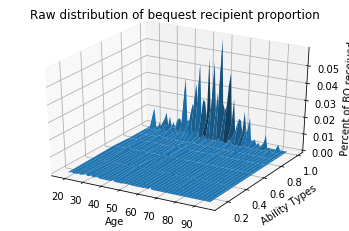

In [3]:
# Solution 1.a.
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

In [4]:
# Solution 1.b.
data = pd.DataFrame(bq_data)
flat_data = pd.DataFrame()
data.columns = lambdas_mdpts
data.index = age_vec#list(map(str, age_vec))
for r in data.index:
    for c in data.columns:
        flat_data = flat_data.append([[r, c, data.loc[r][c]]])

In [5]:
gen_data = pd.DataFrame()
flat_data.index = np.arange(0, 546)
flat_data.columns = ['age', 'percentile', 'p']
ind = np.random.choice(546, 1000, p = flat_data['p'])
gen_data = flat_data.iloc[ind][['age', 'percentile']]

array([[18.        , 18.        , 18.        , ..., 90.        ,
        90.        , 90.        ],
       [ 0.125     ,  0.13378788,  0.14257576, ...,  0.97742424,
         0.98621212,  0.995     ]])

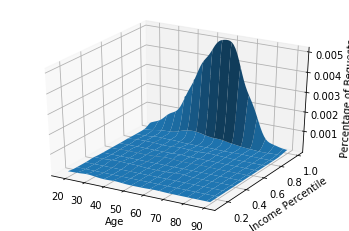

In [6]:
bandwidth = 0.25
kernel = gaussian_kde(gen_data.T, bw_method=bandwidth)

age_min = gen_data['age'].min()
age_max = gen_data['age'].max()
per_min = gen_data['percentile'].min()
per_max = gen_data['percentile'].max()

age_i, per_i = np.mgrid[age_min:age_max:78j,
                              per_min:per_max:100j]
coords = np.vstack([item.ravel() for item in [age_i, per_i]])

Z = np.reshape(kernel(coords), age_i.shape)
Z_scaled = Z / float(np.sum(Z))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_i, per_i, Z_scaled, rstride=5)
ax.set_xlabel("Age")
ax.set_ylabel("Income Percentile")
ax.set_zlabel("Percentage of Bequests")
np.vstack([item.ravel() for item in [age_i, per_i]])

The value of bandwidth is chosen based on 2 conditions:
1. The bottom 80-85% more or less get the same BQ% as compared to the top 20%. Then there is a sharp increase in BQ in the top 15% group. This trend becomes more pronounced with lower bandwidth values.
2. There should be no sudden peak or sudden drop in BQ% for age groups that are close, i.e. the curve has to be smooth. Higher the bandwidth smoother the curve.

From trial and error I found bandwidth = 0.25 to be a decent fit as per the constraints mentioned.

For age = 61 and income group = 90-99th (I took 95th perc to be the average) percentile, the estimated density = 0.0025 (but note that there is highest variance in % BQ for the 90-99th percentile and range is 0.0024 and 0.0049).

In [7]:
Z_scaled[43, 95]

0.002701241885249655

In [8]:
# Solution 2.a.
data = pd.read_csv('data/Auto.csv', na_values=['?'])
data.dropna(inplace=True)
data['mpg_high'] = (data['mpg'] >= data['mpg'].median()).astype(int)
data['orgn1'] = (data['origin'] == 1).astype(int)
data['orgn2'] = (data['origin'] == 2).astype(int)

In [9]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


In [10]:
y = data['mpg_high']
X = data[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']]
N_bs = 100
MSE_vec_bs = np.zeros(N_bs)

start_time = timeit.default_timer()
for bs_ind in range(N_bs):
    random.seed(bs_ind)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.35, random_state=bs_ind)
    # Note: this max_iter value was needed for convergence for lbfgs solver!
    LogReg = LogisticRegression(n_jobs=None, max_iter=1500, solver='lbfgs')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_bs[bs_ind] = ((y_test - y_pred) ** 2).mean()
    # print('MSE for test set', bs_ind, ' is', MSE_vec_bs[bs_ind])
MSE_bs = MSE_vec_bs.mean()
elapsed_time = timeit.default_timer() - start_time

In [11]:
print('Average MSE=', MSE_bs)
print('Computation time=', elapsed_time)

Average MSE= 0.10115942028985506
Computation time= 7.767648037000001


In [12]:
# Solution 2.b
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

Number of available cores is 4


In [13]:
y = data['mpg_high']
X = data[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']]
N_bs = 100
MSE_vec_bs = []

def calc_MSE(bs_ind, X, y):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.35, random_state=bs_ind)
    LogReg = LogisticRegression(max_iter=1500, solver='lbfgs')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    return ((y_test - y_pred) ** 2).mean()

start_time = timeit.default_timer()
for bs_ind in range(N_bs):
    MSE = delayed(calc_MSE(bs_ind, X, y))
    MSE_vec_bs.append(MSE)

MSE_vec_bs = compute(MSE_vec_bs)
MSE_bs = np.mean(MSE_vec_bs[0])
elapsed_time = timeit.default_timer() - start_time

In [14]:
print('Average MSE=', MSE_bs)
print('Computation time=', elapsed_time)

Average MSE= 0.10115942028985506
Computation time= 9.057429677999991


So the computation time drops with parallelization, while the error rate is the same